In [2]:
import datetime
from csbdeep.io import load_training_data
from csbdeep.utils import axes_dict, plot_some, plot_history
import matplotlib.pyplot as plt
from actin_tubules_sim.models import Denoiser, DFCAN
from actin_tubules_sim.loss import mse_ssim
import tensorflow as tf
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

In [3]:
root_dir = '/Users/vkapoor/Downloads/Microtubules'
model_dir = os.path.join(root_dir, 'DenoisingCARE/')
os.makedirs(model_dir, exist_ok=True)
train_data_file = f'{root_dir}/Train/DN/microtubule_dn_training_data.npz'
log_dir = "logs/fitDN/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [4]:
(X,Y), (X_val,Y_val), axes = load_training_data(train_data_file, validation_split=0.1, verbose=True)

c = axes_dict(axes)['C']
n_channel_in, n_channel_out = X.shape[c], Y.shape[c]

X = tf.squeeze(X, axis=-1)
X_val = tf.squeeze(X_val, axis=-1)
Y = tf.squeeze(Y, axis=-1)
Y_val = tf.squeeze(Y_val, axis=-1)
X = tf.transpose(X, perm=[0, 2, 3, 1])
X_val = tf.transpose(X_val, perm=[0, 2, 3, 1])
Y = tf.transpose(Y, perm=[0, 2, 3, 1])
Y_val = tf.transpose(Y_val, perm=[0, 2, 3, 1])


number of training images:	 495
number of validation images:	 55
image size (3D):		 (9, 128, 128)
axes:				 SZYXC
channels in / out:		 1 / 1


In [5]:
X.shape,Y.shape,X_val.shape

(TensorShape([495, 128, 128, 9]),
 TensorShape([495, 128, 128, 9]),
 TensorShape([55, 128, 128, 9]))

Text(0.5, 0.98, '5 example validation patches (top row: source, bottom row: target)')

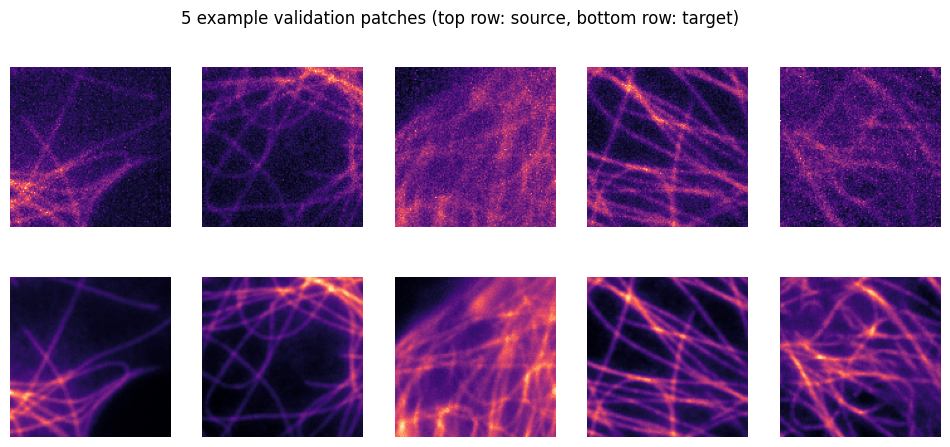

In [6]:
plt.figure(figsize=(12,5))
plot_some(tf.transpose(X_val[:5], perm=[0, 3, 1, 2]),tf.transpose(Y_val[:5], perm=[0, 3, 1, 2]))
plt.suptitle('5 example validation patches (top row: source, bottom row: target)')

In [7]:
init_lr = 1e-4
batch_size = 3
epochs = 10
beta_1=0.9
beta_2=0.999
wavelength = 0.488 
excNA = 1.35
dx = 62.6e-3
dy = dx
dxy = dx 
scale_gt = 2.0
setupNUM = 1
space = wavelength/excNA
k0mod = 1 / space
napodize = 10
if setupNUM == 0:
     k0angle_c = [1.48, 2.5272, 3.5744]
     k0angle_g = [0.0908, -0.9564, -2.0036]  
if setupNUM == 1:
     k0angle_c = [-1.66, -0.6128, 0.4344]
     k0angle_g = [3.2269, 2.1797, 1.1325]      
if setupNUM == 2:
     k0angle_c = [1.5708, 2.618, 3.6652]
     k0angle_g = [0, -1.0472, -2.0944] 
total_data,  height, width, channels = X.shape

In [ ]:
parameters = {
    'Ny': height,
    'Nx': width,
    'wavelength':wavelength,
    'excNA':excNA,
    'ndirs':3,
    'nphases':3,
    'init_lr': 1e-4,
    'batch_size': 3,
    'epochs': 10,
    'beta_1':0.9,
    'beta_2':0.999,
    'scale_gt': 2.0,
    'setupNUM': setupNUM,
    'k0angle_c':k0angle_c,
    'k0angle_g':k0angle_g,
    'dxy':dxy,
    'space':space,
    'k0mod':k0mod,
    'napodize':napodize,
    'scale': scale_gt
}

In [ ]:
Trainingmodel_dfcan = DFCAN((height, width, channels), scale=scale_gt)
optimizer = Adam(learning_rate=init_lr, beta_1=beta_1, beta_2=beta_2)
Trainingmodel_dfcan.compile(loss=mse_ssim, optimizer=optimizer)
Trainingmodel_dfcan.summary()

tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
lrate = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=1)
hrate = callbacks.History()

In [15]:
Trainingmodel = Denoiser((height, width, phases))
optimizer = Adam(learning_rate=init_lr, beta_1=beta_1, beta_2=beta_2)
Trainingmodel.compile(loss=mse_ssim, optimizer=optimizer)
Trainingmodel.summary()

tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
lrate = callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=1)
hrate = callbacks.History()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 9)]        0         []                            
                                                                                                  
 conv2d_42 (Conv2D)          (None, 128, 128, 64)         5248      ['input_2[0][0]']             
                                                                                                  
 leaky_re_lu_22 (LeakyReLU)  (None, 128, 128, 64)         0         ['conv2d_42[0][0]']           
                                                                                                  
 conv2d_43 (Conv2D)          (None, 128, 128, 64)         36928     ['leaky_re_lu_22[0][0]']      
                                                                                              

## Training
Training the model will likely take some time. We recommend to monitor the progress with [TensorBoard](https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard), which allows you to inspect the losses during training.

You can start TensorBoard from the current working directory with `tensorboard --logdir=.` Then connect to http://localhost:6006/ with your browser.

In [16]:
history = Trainingmodel.fit(X, Y, batch_size=batch_size,
                               epochs=epochs, validation_data=(X_val, Y_val), shuffle=True,
                               callbacks=[lrate, hrate, tensorboard_callback])

Epoch 1/10


ValueError: in user code:

    File "/Users/vkapoor/miniconda3/envs/kapoorlabsenv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/Users/vkapoor/miniconda3/envs/kapoorlabsenv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/vkapoor/miniconda3/envs/kapoorlabsenv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/Users/vkapoor/miniconda3/envs/kapoorlabsenv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/Users/vkapoor/miniconda3/envs/kapoorlabsenv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/vkapoor/miniconda3/envs/kapoorlabsenv/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(3, 128, 128, 9) dtype=float32>]


In [ ]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss'])